The goal of this notebook is to explore the different options I have for defining "sharedness" or "prevalence of exchange" (synonymous).

Specifically
- which samples should I use to define the shared OTUs?
    - all samples with MBS status?
    - all samples with the given site combination?
        - which samples does this include? i.e. how many non-K23 samples would this be?
- does the choice of samples for the definition affect the interpretation?

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

df = pd.read_csv(fnotu, sep='\t', index_col=0)
meta = pd.read_csv(fnmeta, sep='\t', index_col=0)

mbscol = 'mbs_consolidated'

In [3]:
# How many patients have multiple samples per site?
sites = ['gastric_fluid', 'throat_swab', 'bal']
for s in sites:
    print(s, Counter(meta.query('site == @s').groupby(['subject_id']).size()))

('gastric_fluid', Counter({1: 179, 2: 1}))
('throat_swab', Counter({1: 159, 2: 45}))
('bal', Counter({1: 131}))


An explanation of what the cell below does, where `subdf` is the same object as what's returned by `meta.query('site == @sites').query('subject_id == "01-230-9"')`:

```python
> meta.query('site == @sites').query('subject_id == "01-230-9"').groupby('site').size()
site
gastric_fluid    2
throat_swab      1
dtype: int64

# Shape of the grouped-by site df is how many different sites are sampled
> meta.query('site == @sites').query('subject_id == "01-230-9"').groupby('site').size().shape
(2,)

# If any of the values are greater than 1, keep track of that sample
> meta.query('site == @sites').query('subject_id == "01-230-9"').groupby('site').size().values
array([2, 1])
```

In [4]:
# Of patients with at least 2 different sites of interest sampled,
# how many have duplicate samples for one of the sites?
subjs = []
for subj, subdf in meta.query('site == @sites').groupby('subject_id'):
    if subdf.groupby('site').size().shape[0] > 1:
        if sum(subdf.groupby('site').size().values > 1) > 0:
            subjs.append(subj)
print('{} subjects have multiple sites of interest sampled and '
      'duplicate samples for at least one of those sites.'.format(len(subjs)))          

2 subjects have multiple sites of interest sampled and duplicate samples for at least one of those sites.


In [5]:
meta.query('subject_id == @subjs')[['subject_id', 'site']]

,subject_id,site
01-230-9GF,01-230-9,gastric_fluid
01-230-9GI,01-230-9,gastric_fluid
01-230-9RF,01-230-9,rectal_swab
01-230-9RI,01-230-9,rectal_swab
01-230-9TF,01-230-9,throat_swab
01-263-4GI,01-263-4,gastric_fluid
01-263-4RI,01-263-4,rectal_swab
01-263-4TF,01-263-4,throat_swab
01-263-4TI,01-263-4,throat_swab


In [6]:
# Hm, this makes me wonder.. how many of those other subjects are post-fundoplication?
smpls = []
for subj, subdf in meta.query('site == @sites').groupby('subject_id'):
    if subdf.groupby('site').size().shape[0] > 1:
        smpls += list(subdf.index)

In [7]:
# The two that were found above, plus two others
[i for i in smpls if i.endswith('F')]

['01-230-9GF',
 '01-230-9TF',
 '01-263-4TF',
 '13-112-7GF',
 '13-112-7TF',
 '13-164-7GF',
 '13-164-7TF']

In [8]:
# Strange bc these samples are part of the K23 study. 
# Not sure what the F means (I would guess it's either pre/post fundo or pre/post PPI, 
# but those are 'Fundo' and 'R01' studies...)
meta.loc[smpls, 'STUDY'].unique()

array([nan, 'K23'], dtype=object)

In [9]:
smpls = [i for i in smpls if not i.endswith('F')]
print('{} samples correspond to multiple sites within a patient. '
      'Of these, {} have aspiration metadata.'\
      .format(len(smpls), meta.loc[smpls, mbscol].dropna().shape[0]))


427 samples correspond to multiple sites within a patient. Of these, 253 have aspiration metadata.


### Make some scatterplots

Plot abundance in site1 vs. in site 2 for all OTUs, colored by aspiration status.   
Also include the correlation value on the plot.    
And maybe separate out by yes/no "exchanged"?

In [10]:
## First, make a tidy dataframe that I can query for downstream comparisons
def site_comp(site1, site2):
    comp = 'unk'
    if site1 == 'bal' and site2 == 'bal':
        comp = 'bal_bal'
    elif site1 == 'bal' and site2 == 'throat_swab':
        comp = 'bal_throat'
    elif site1 == 'bal' and site2 == 'gastric_fluid':
        comp = 'bal_gastric'

    elif site1 == 'throat_swab' and site2 == 'bal':
        comp = 'bal_throat'
    elif site1 == 'throat_swab' and site2 == 'throat_swab':
        comp = 'throat_throat'
    elif site1 == 'throat_swab' and site2 == 'gastric_fluid':
        comp = 'throat_gastric'

    elif site1 == 'gastric_fluid' and site2 == 'bal':
        comp = 'bal_gastric'
    elif site1 == 'gastric_fluid' and site2 == 'throat_swab':
        comp = 'throat_gastric'
    elif site1 == 'gastric_fluid' and site2 == 'gastric_fluid':
        comp = 'gastric_gastric'
    return comp

# Note that I'll be getting rid of samples that end in 'F'. 
# Not sure what these samples correspond to,
# and subjects 01-230-9 and 01-263-4 have duplicate samples from the same site,
# one of which is labeled GI (or TI) and the other is GF (or TF) - so removing
# samples that end in F also address this situation

In [11]:
lst_tidymeta = []
for subj, subdf in meta.query('site == @sites').groupby('subject_id'):
    if subdf.groupby('site').size().shape[0] > 1:
        smpls = list(subdf.index)
        
        # Get rid of any samples that end in 'F'
        smpls = [i for i in smpls if not i.endswith('F')]
        if len(smpls) == 0:
            continue
            
        asp = subdf.loc[smpls[0], mbscol]
        for s1 in smpls:
            site1 = subdf.loc[s1, 'site']
            for s2 in smpls[smpls.index(s1)+1:]:
                site2 = subdf.loc[s2, 'site']
                lst_tidymeta.append([subj, s1, s2, site_comp(site1, site2), asp])
tidymeta = pd.DataFrame(data=lst_tidymeta, 
                        columns=['subject', 'sample1', 'sample2', 'site_comparison', mbscol])

In [13]:
tidymeta.head(15)

,subject,sample1,sample2,site_comparison,mbs_consolidated
0,01-112-7,01-112-7GI,01-112-7TI,throat_gastric,NaN
1,01-164-7,01-164-7GI,01-164-7TI,throat_gastric,NaN
2,01-173-4,01-173-4G,01-173-4T,throat_gastric,NaN
3,01-247-3,01-247-3G,01-247-3T,throat_gastric,NaN
4,01-263-4,01-263-4GI,01-263-4TI,throat_gastric,NaN
5,01-270-3,01-270-3G,01-270-3T,throat_gastric,NaN
6,02-096-6,02-096-6B,02-096-6G,bal_gastric,Normal
7,02-096-6,02-096-6B,02-096-6T,bal_throat,Normal
8,02-096-6,02-096-6G,02-096-6T,throat_gastric,Normal
9,02-098-5,02-098-5B,02-098-5G,bal_gastric,Normal


In [31]:
from scipy.stats import spearmanr

def get_exchange_and_correlation_old(col, s1smpls, s2smpls):
    """
    Get the sharedness and correlation values for the values in col,
    comparing samples in s1smpls and s2smpls lists.

    Prevalence of exchange is calculated as the number of samples with
    non-zero abundance in both subjects divided by total subjects.

    Sharedness is 0 and correlation is 0 if fewer than 3 of the
    samples have the OTU in both sites.

    Parameters
    ----------
    col : pandas Series
        Values to correlate and calculate 'exchange' for, e.g. relative
        abundances of one OTU. Index should have at least s1smpls and
        s2smpls. Values in col are log-transformed relative abundances,
        where infinities have been replaced with nan's.
    s1smpls, s2smpls :  lists
        Samples to consider. Should be the same length and paired (i.e. the
        first sample in s1smpls comes from the same patient as the first
        sample in s2smpls.)

    Returns:
    -------
    corrs : tuple
        (r, p, sharedness)
    """
    x = col.loc[s1smpls]
    y = col.loc[s2smpls]
    ## Get correlation of x and y, ignoring infinities
    try:
        r, p = spearmanr(x, y, nan_policy='omit')
        ## Don't think I need the following code, but keep it just in case
        ## with nan_policy='omit', need to get p out of a masked array
        #if isinstance(p, np.ma.core.MaskedArray):
        #    p = p.compressed()[0]
        sharedness = sum([1 if np.isnan(x[i]) or np.isnan(y[i]) else 0
                          for i in range(0, len(x))]) \
                     / float(len(x) + len(y))
    except ValueError as e:
        # This error means that fewer than 3 of the samples have OTU in both sites...
        if e.message == "The input must have at least 3 entries!":
            r = 0
            p = 1
            sharedness = 0
        else:
            raise

    return (r, p, sharedness)

In [32]:
## Make some plots

# Log transform relative abundances
dflog = df.applymap(np.log10)
# Replace log(zero)'s with nan's
dflog = dflog.applymap(lambda x: x if np.isfinite(x) else np.nan)

s1smpls = tidymeta.query('site_comparison == "bal_throat"')['sample1']
s2smpls = tidymeta.query('site_comparison == "bal_throat"')['sample2']

corrs = dflog.apply(lambda col: get_exchange_and_correlation_old(col, s1smpls, s2smpls))

/Users/claire/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6


In [ ]:
corrs = pd.DataFrame(corrs, columns=['results'])
corrs['r'] = corrs['results'].apply(lambda x: x[0])
corrs['p'] = corrs['results'].apply(lambda x: x[1])
corrs['exchange_all'] = corrs['results'].apply(lambda x: x[2])
corrs = corrs.drop('results', axis=1)

In [49]:
corrs.query('r > 0').head(15)

,r,p,exchange_all
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__;d__denovo883,0.300000,0.623838,0.473404
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__;s__;d__denovo1421,0.500000,0.666667,0.484043
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323,0.499248,0.025022,0.393617
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__;d__denovo327,0.142857,0.759945,0.462766
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia;s__;d__denovo326,1.000000,0.000000,0.489362
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo1195,1.000000,0.000000,0.484043
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella;s__;d__denovo1811,1.000000,0.000000,0.489362
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo184,0.317647,0.230573,0.414894
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__;d__denovo182,1.000000,0.000000,0.489362
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo180,0.107692,0.714031,0.425532


In [71]:
o = 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo614'

tmp1 = dflog.loc[s1smpls, o]
tmp1.index = [i[:-1] for i in tmp1.index]
tmp2 = dflog.loc[s2smpls, o]
tmp2.index = [i[:-1] for i in tmp2.index]

pd.concat((tmp1, tmp2), axis=1).dropna()


,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo614,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo614
04-182-6,-4.774079,-4.013995
04-201-8,-4.500813,-2.401805


### Oh right, I need to limit my analysis to OTUs which are non-zero in both sites in at least 3 patients

Previously, I had set this limit with `n_patients`. I had arbitrarily chosen 10, 
but I think I can just go with the minimum value that makes sense (i.e. 3, because
we're doing correlation...)

In [124]:
def get_exchange_and_correlation_also_old(col, s1smpls, s2smpls):
    """
    Get the sharedness and correlation values for the values in col,
    comparing samples in s1smpls and s2smpls lists.

    Prevalence of exchange is calculated as the number of samples with
    non-zero abundance in both subjects divided by total subjects.

    Correlation, p, and sharedness are all NaN if the OTU is present in
    both sites in fewer than 4 patients.

    Parameters
    ----------
    col : pandas Series
        Values to correlate and calculate 'exchange' for, e.g. relative
        abundances of one OTU. Index should have at least s1smpls and
        s2smpls. Values in col are log-transformed relative abundances,
        where infinities have been replaced with nan's.
    s1smpls, s2smpls :  lists
        Samples to consider. Should be the same length and paired (i.e. the
        first sample in s1smpls comes from the same patient as the first
        sample in s2smpls.)

    Returns:
    -------
    corrs : tuple
        (r, p, sharedness)
    """
    x = col.loc[s1smpls]
    y = col.loc[s2smpls]
    
    ## If there are more than 3 patients with non-zero abundance in both sites
    nonzero = sum([i and j for i, j in zip(x.notnull().values, y.notnull().values)])
    if nonzero > 3:
        ## Get correlation of x and y, ignoring infinities
        try:
            r, p = spearmanr(x, y, nan_policy='omit')
            ## Don't think I need the following code, but keep it just in case
            ## with nan_policy='omit', need to get p out of a masked array
            #if isinstance(p, np.ma.core.MaskedArray):
            #    p = p.compressed()[0]
            sharedness = sum([1 if np.isnan(x[i]) or np.isnan(y[i]) else 0
                              for i in range(0, len(x))]) \
                         / float(len(x) + len(y))
        except ValueError as e:
            # This error means that fewer than 3 of the samples have OTU in both sites...
            if e.message == "The input must have at least 3 entries!":
                r = 0
                p = 1
                sharedness = 0
            else:
                raise
    else:
        r = np.nan
        p = np.nan
        sharedness = np.nan

    return (r, p, sharedness)

In [126]:
corrs = dflog.apply(lambda col: get_exchange_and_correlation(col, s1smpls, s2smpls))

In [127]:
corrs = pd.DataFrame(corrs, columns=['results'])
corrs['r'] = corrs['results'].apply(lambda x: x[0])
corrs['p'] = corrs['results'].apply(lambda x: x[1])
corrs['exchange_all'] = corrs['results'].apply(lambda x: x[2])
corrs = corrs.drop('results', axis=1)
corrs.query('r > 0').head(15)

,r,p,exchange_all
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__;d__denovo883,0.300000,0.623838,0.473404
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323,0.499248,0.025022,0.393617
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__;d__denovo327,0.142857,0.759945,0.462766
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo184,0.317647,0.230573,0.414894
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo180,0.107692,0.714031,0.425532
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Streptobacillus;s__;d__denovo432,0.816667,0.007225,0.452128
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Cardiobacteriaceae;g__Cardiobacterium;s__;d__denovo431,0.321429,0.482072,0.462766
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Tannerella;s__;d__denovo653,0.714286,0.110787,0.468085
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo1504,0.800000,0.200000,0.478723
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__;d__denovo330,1.000000,0.000000,0.478723


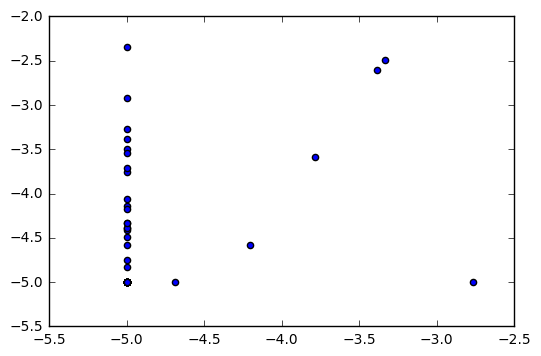

In [130]:
o = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__;d__denovo330'
plt.scatter(dflog.loc[s1smpls, o].replace(np.nan, -5), dflog.loc[s2smpls, o].replace(np.nan, -5))

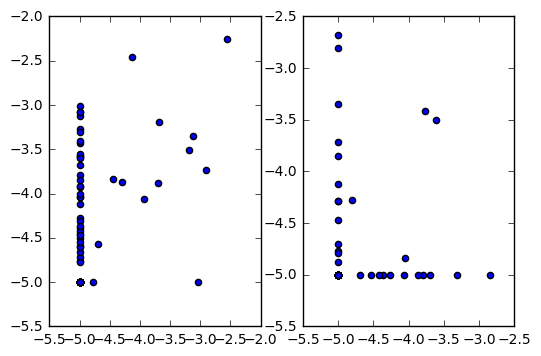

In [131]:
# o1 has r = 0.6 and p = 0.04
# o2 has r = 0.6 and p = 0.4

o1 = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;s__;d__denovo604'
o2 = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__;d__denovo709'

fig, ax = plt.subplots(1,2)
ax[0].scatter(dflog.loc[s1smpls, o1].replace(np.nan, -5), dflog.loc[s2smpls, o1].replace(np.nan, -5))
ax[1].scatter(dflog.loc[s1smpls, o2].replace(np.nan, -5), dflog.loc[s2smpls, o2].replace(np.nan, -5))

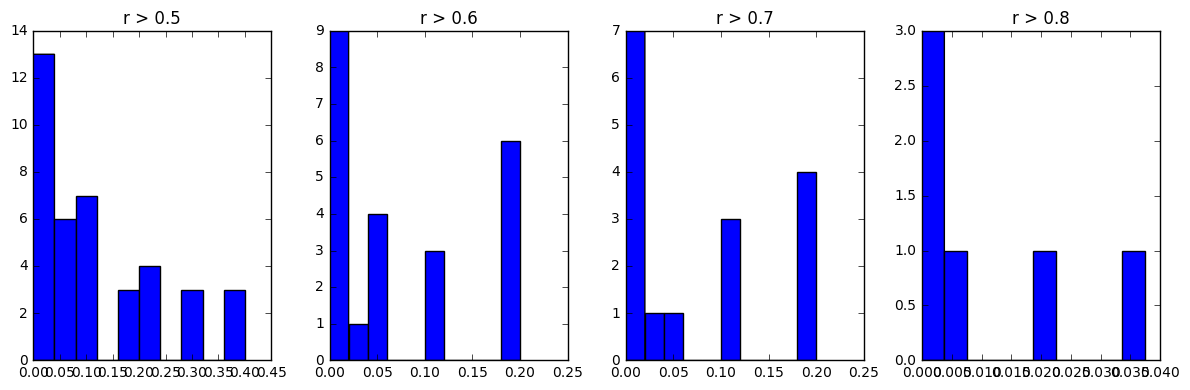

In [136]:
# Right - because we have different numbers of patients with the OTU non-zero 
# in both sites, we can get same correlation values with very different support.

# Do we want to just ignore p-value in determining which OTUs are shared? That seems
# fishy. Seems like we may need to consider both p-value and correlation value...

# Look at the distribution of p-values by correlation threshold cutoff
fig, ax = plt.subplots(1, 4, figsize=(12,4))
i = 0
for r in [0.5, 0.6, 0.7, 0.8]:
    ax[i].hist(corrs.query('r > @r')['p'])
    ax[i].set_title('r > {}'.format(r))
    i += 1
fig.tight_layout()

### Actually, let's go back to having an `n_patients` threshold

This way, we get around the problem of having high correlation but high p-value (i.e. low support bc few samples).

If we already filter OTUs which are non-zero in both sites in at least 10 patients, then we can just
define `exchanged` OTUs based on the correlation value (and not worry about the p-value. Hopefully).

In [137]:
def get_exchange_and_correlation(col, s1smpls, s2smpls, n_patients):
    """
    Get the sharedness and correlation values for the values in col,
    comparing samples in s1smpls and s2smpls lists.

    Prevalence of exchange is calculated as the number of samples with
    non-zero abundance in both subjects divided by total subjects.

    Correlation, p, and sharedness are all NaN if the OTU is present in
    both sites in fewer than 4 patients.

    Parameters
    ----------
    col : pandas Series
        Values to correlate and calculate 'exchange' for, e.g. relative
        abundances of one OTU. Index should have at least s1smpls and
        s2smpls. Values in col are log-transformed relative abundances,
        where infinities have been replaced with nan's.
    
    s1smpls, s2smpls :  lists
        Samples to consider. Should be the same length and paired (i.e. the
        first sample in s1smpls comes from the same patient as the first
        sample in s2smpls.)
    
    n_patients : int
        number of patients in which OTU must be non-zero in both sites
        to be considered as putatively 'exchanged'.
        
    Returns:
    -------
    corrs : tuple
        (r, p, sharedness)
    """
    x = col.loc[s1smpls]
    y = col.loc[s2smpls]
    
    ## If there are more than 3 patients with non-zero abundance in both sites
    nonzero = sum([i and j for i, j in zip(x.notnull().values, y.notnull().values)])
    if nonzero >= n_patients:
        ## Get correlation of x and y, ignoring infinities
        try:
            r, p = spearmanr(x, y, nan_policy='omit')
            ## Don't think I need the following code, but keep it just in case
            ## with nan_policy='omit', need to get p out of a masked array
            #if isinstance(p, np.ma.core.MaskedArray):
            #    p = p.compressed()[0]
            sharedness = sum([1 if np.isnan(x[i]) or np.isnan(y[i]) else 0
                              for i in range(0, len(x))]) \
                         / float(len(x) + len(y))
        except ValueError as e:
            # This error means that fewer than 3 of the samples have OTU in both sites...
            if e.message == "The input must have at least 3 entries!":
                r = 0
                p = 1
                sharedness = 0
            else:
                raise
    else:
        r = np.nan
        p = np.nan
        sharedness = np.nan

    return (r, p, sharedness)

In [142]:
corrs = dflog.apply(lambda col: get_exchange_and_correlation(col, s1smpls, s2smpls, 10))

In [143]:
corrs = pd.DataFrame(corrs, columns=['results'])
corrs['r'] = corrs['results'].apply(lambda x: x[0])
corrs['p'] = corrs['results'].apply(lambda x: x[1])
corrs['exchange_all'] = corrs['results'].apply(lambda x: x[2])
corrs = corrs.drop('results', axis=1)

In [151]:
corrs.query('r > 0.5').sort_values(by='r', ascending=False)

,r,p,exchange_all
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo287,0.754545,0.007282,0.441489
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo1237,0.734266,0.006543,0.436170
k__Bacteria;p__SR1;c__;o__;f__;g__SR1_genera_incertae_sedis;s__;d__denovo210,0.664216,0.003636,0.409574
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo838,0.636364,0.047912,0.446809
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__;d__denovo82,0.621429,0.013402,0.420213
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;s__;d__denovo604,0.609091,0.046696,0.441489
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo412,0.609091,0.046696,0.441489
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__;d__denovo288,0.586674,0.004105,0.382979
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo306,0.557895,0.013060,0.398936
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo409,0.549451,0.051771,0.430851


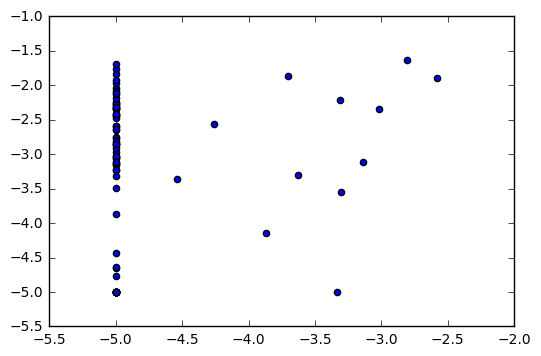

In [147]:
o = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Syntrophococcus;s__;d__denovo70'
plt.scatter(dflog.loc[s1smpls, o].replace(np.nan, -5), dflog.loc[s2smpls, o].replace(np.nan, -5))

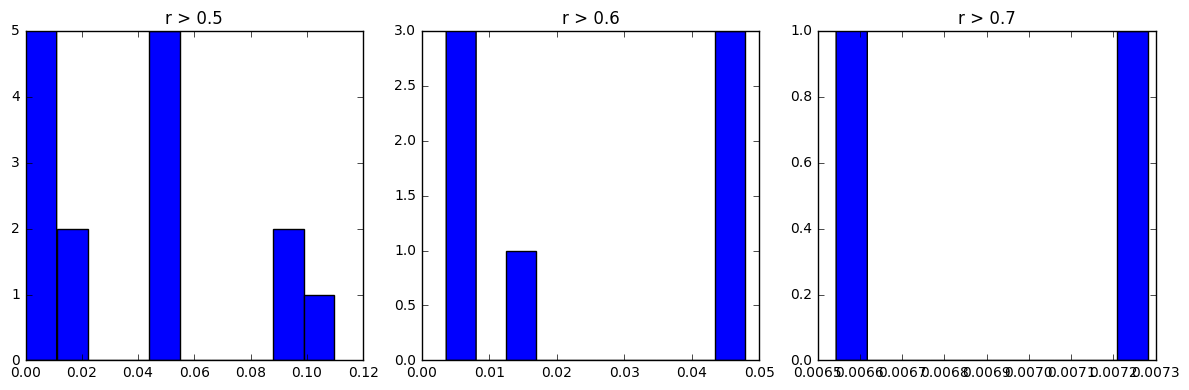

In [149]:
# Look at the distribution of p-values by correlation threshold cutoff
fig, ax = plt.subplots(1, 3, figsize=(12,4))
i = 0
for r in [0.5, 0.6, 0.7]:
    ax[i].hist(corrs.query('r > @r')['p'])
    ax[i].set_title('r > {}'.format(r))
    i += 1
fig.tight_layout()

In [152]:
## What about for a different site comparison?

s1smpls = tidymeta.query('site_comparison == "bal_throat"')['sample1']
s2smpls = tidymeta.query('site_comparison == "bal_throat"')['sample2']

corrs = dflog.apply(lambda col: get_exchange_and_correlation(col, s1smpls, s2smpls, 10))

In [153]:
corrs.head()

k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Acidaminococcaceae;g__Phascolarctobacterium;s__;d__denovo58      (nan, nan, nan)
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XIII;g__Anaerovorax;s__;d__denovo1106    (nan, nan, nan)
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus2;s__;d__denovo57                      (nan, nan, nan)
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__;d__denovo886            (nan, nan, nan)
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__;d__denovo887                                  (nan, nan, nan)
dtype: object

### Stop here

Clearly the data file I need is tidy dataframe with `otu`, `r`, `p`, `exchange`, `site_comparison`, and `min_patients`, where `min_patients` is the presence threshold for consideration (i.e. OTU must be non-zero in both sites in at least `min_patients` to even get considered as "shared").